# MOBO Workshop Demo

Welcome! This demo shows a complete **Multi-Objective Bayesian Optimization (MOBO)** workflow that only
requires you to provide a single **CSV** with your inputs and objectives, then set a **save path** where
outputs are written.

**You will edit just two things:**
1. `csv_path` → point to your data file
2. `save_path` → directory for results and plots

## Outline
- [0. Setup & Imports](#0-Setup--Imports)
- [1. Load Your Data](#1-Load-Your-Data)  
  - [Existing data present](#Existing-data-present)  
  - [Starting from scratch / LHS](#Starting-from-scratch--LHS)
- [2. Normalize & Convert to Tensors](#Inputs-%E2%86%92-01)
- [3. Fit Gaussian Process (GP) Models](#3-Fit-Gaussian-Process-GP-Models)
- [4. LOOCV Model Selection (optional)](#4-loocv_select_models-optional)
- [5. Posterior Predictions and Diagnostics](#5-Posterior-Predictions-and-Diagnostics)
- [6. Acquisition & Proposing New Batches](#6-Acquisition)
- [7. Candidate Analysis & Visualization](#X_next--Candidate-Analysis)
- [8. Visualize Progress (Hypervolume & Pareto)](#8-Visualize-Progress)
- [9. Save Results](#9-save-outputs)


## 0. Setup & Imports


**Imports** Bring in libraries for data handling, modeling, and plotting.  
If CUDA isn't available, the CPU path still works for a workshop-scale demo.


In [3]:
# --- Imports & setup ---
%load_ext autoreload
%autoreload 2

# Core
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Torch / BoTorch / GPyTorch
import torch
from mobo_kit.utils import csv_to_config, split_XY, get_objective_names, np_to_torch
from mobo_kit.design import build_design_from_config

from mobo_kit.lhs import lhs_dataframe, lhs_dataframe_optimized
from mobo_kit.constraints import constraints_from_config

from mobo_kit.plotting import plot_distribution, plot_correlation_heatmap, plot_PCA

from mobo_kit.data import x_normalizer_np

from mobo_kit.models import fit_gp_models
from mobo_kit.constraints import check_clausius_clapeyron_np
from mobo_kit.lhs import lhs_dataframe
#from mobo_kit.plotting import plot_pareto, plot_hypervolume_trajectory

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## Point to CSV and save path

In [2]:
# Path to your CSV (change for your data)
csv_path = "../data/processed/configCSV_example.csv"
save_path = "../results/demo"

## 1. Load Your Data


## Step 1 — Load CSV → Build Config & Design (two use cases)

This notebook supports **two starting points**:

1) [Existing data present](#Existing-data-present)   
   - CSV has header rows (units/start/stop/step), then data rows.
   - We’ll build a `config`, create a `design`, then split into inputs `X` and objectives `Y`.

2) [Starting from scratch](#starting-from-scratch-no-data-yet)
   - CSV has header rows only (units/start/stop/step), no data rows.
   - We’ll still build `config` and `design`, but skip data split and instead **generate an initial LHS** for you to run in the lab.

> Tip: The expected CSV layout:
> - Row 1: **variable_names**  
> - Row 2: **units**  
> - Row 3: **start** values  
> - Row 4: **stop** values  
> - Row 5: **step** values 
> - Row 6: **empty** 
> - Row 7+: experimental data (if you have any)


<a id="existing-data-present"></a>

### Existing data present

If your CSV already has experimental results (rows 6 and below):

We will:
1. Convert the CSV into a config dictionary.  
2. Build a `Design` object that stores variable ranges and grids.  
3. Split into `X` (inputs) and `Y` (objectives).

In [3]:
# 1. Convert CSV to config dict + YAML
config = csv_to_config(csv_path, output_path=os.path.join("../configs", "demo_config.yaml"))

# 2. Build design space from config
design = build_design_from_config(config)

# 3. Load CSV fully, then split into X, Y
df = pd.read_csv(csv_path)
X_df, Y_df = split_XY(df, design, config)

print("Design inputs:", design.names)
print("Lower bounds:", design.lowers)
print("Upper bounds:", design.uppers)
print("Steps:", design.steps)
print("Objectives:", config["objectives"]["names"])
print("X shape:", X_df.shape, "Y shape:", Y_df.shape)

display(pd.DataFrame(X_df, columns=design.names).head())
obj_names = get_objective_names(config)
display(pd.DataFrame(Y_df, columns=obj_names).head())

Design inputs: ['speed_inorg', 'speed_org', 'inkfl_inorg', 'inkfl_org', 'conc_inorg', 'conc_org', 'temperature_c', 'absolute_humidity']
Lower bounds: [  0.25   0.25  80.   100.     0.8    0.4   20.     2.  ]
Upper bounds: [  1.    1.  240.  280.    1.4   1.2  50.   37. ]
Steps: [0.01 0.01 1.   1.   0.05 0.05 1.   1.  ]
Objectives: ['PCE', 'Stability', 'Repeatability']
X shape: (11, 8) Y shape: (11, 3)


,speed_inorg,speed_org,inkfl_inorg,inkfl_org,conc_inorg,conc_org,temperature_c,absolute_humidity
6,0.95,0.58,170.0,246.0,0.90,0.85,44.0,19.0
7,0.67,0.95,150.0,179.0,1.05,1.15,31.8,6.0
8,0.77,0.39,130.0,269.0,1.15,0.65,28.5,6.0
9,0.39,0.67,230.0,201.0,1.20,0.55,41.6,15.0
10,0.30,0.86,90.0,224.0,1.30,0.95,41.6,19.0


,PCE,Stability,Repeatability
6,0.00,0.00,10.000000
7,0.00,0.00,10.000000
8,0.00,0.00,10.000000
9,10.69,1.35,3.333333
10,0.00,0.00,10.000000


### Starting from scratch / LHS

If your CSV only has the **metadata rows** (variable names, units, start, stop, step) but **no data rows**,  
we generate an **initial batch** of experiments using **Latin Hypercube Sampling (LHS)**.  
This ensures your first experiments cover the parameter space evenly.

We will:
1. Convert the CSV into a config dictionary.  
2. Build a `Design` object that stores variable ranges and grids.  
3. Add constraints (if necessary)
4. Generate an LHS dataframe of a given batch size.

In [4]:
# 1. Convert CSV to config dict + YAML
config = csv_to_config(csv_path, output_path=os.path.join("../configs", "auto_config.yaml"))

# 2. Build design space from config
design = build_design_from_config(config)
df = pd.read_csv(csv_path)
obj_names = get_objective_names(config)

#3. Add constraints (if necessary)
row_constraints = constraints_from_config(config, design)
max_abs_corr = 0.2

#4. Generate an LHS dataframe of a given batch size.
lhs_batch_size = 20
lhs_df = lhs_dataframe_optimized(design, n=lhs_batch_size, seed=42, row_constraints=row_constraints, max_abs_corr=max_abs_corr, verbose=True)
display(lhs_df.head())
print(f"Objective names: {obj_names}")


[OPTIMIZED LHS] Target: 20 samples, Generating: 100 samples
[OPTIMIZED LHS] Attempt 1: max|corr|=0.307 (tries: 9)
[OPTIMIZED LHS] Attempt 2: max|corr|=0.271 (tries: 8)
[OPTIMIZED LHS] Attempt 3: max|corr|=0.275 (tries: 9)
[OPTIMIZED LHS] Attempt 4: max|corr|=0.281 (tries: 7)
[OPTIMIZED LHS] Attempt 5: max|corr|=0.284 (tries: 7)
[OPTIMIZED LHS] Attempt 6: max|corr|=0.286 (tries: 8)
[OPTIMIZED LHS] Attempt 7: max|corr|=0.271 (tries: 5)
[OPTIMIZED LHS] Attempt 8: max|corr|=0.281 (tries: 8)
[OPTIMIZED LHS] Attempt 9: max|corr|=0.277 (tries: 5)
[OPTIMIZED LHS] Attempt 10/100
[OPTIMIZED LHS] Attempt 10: max|corr|=0.284 (tries: 6)
[OPTIMIZED LHS] Attempt 11: max|corr|=0.242 (tries: 9)
[OPTIMIZED LHS] Attempt 12: max|corr|=0.262 (tries: 8)
[OPTIMIZED LHS] Attempt 13: max|corr|=0.253 (tries: 8)
[OPTIMIZED LHS] Attempt 14: max|corr|=0.229 (tries: 11)
[OPTIMIZED LHS] Attempt 15: max|corr|=0.271 (tries: 8)
[OPTIMIZED LHS] Attempt 16: max|corr|=0.284 (tries: 4)
[OPTIMIZED LHS] Attempt 17: max|corr|

,speed_inorg,speed_org,inkfl_inorg,inkfl_org,conc_inorg,conc_org,temperature_c,absolute_humidity
0,0.79,0.37,233.0,257.0,1.40,1.15,33.0,3.0
1,0.41,0.97,175.0,153.0,0.95,0.65,29.0,12.0
2,0.85,0.64,199.0,160.0,1.10,0.50,47.0,28.0
3,0.52,0.43,81.0,202.0,1.30,0.65,30.0,26.0
4,0.63,0.87,218.0,184.0,1.15,0.75,30.0,28.0


Objective names: ['PCE', 'Stability', 'Repeatability']


### Visualize data distribution


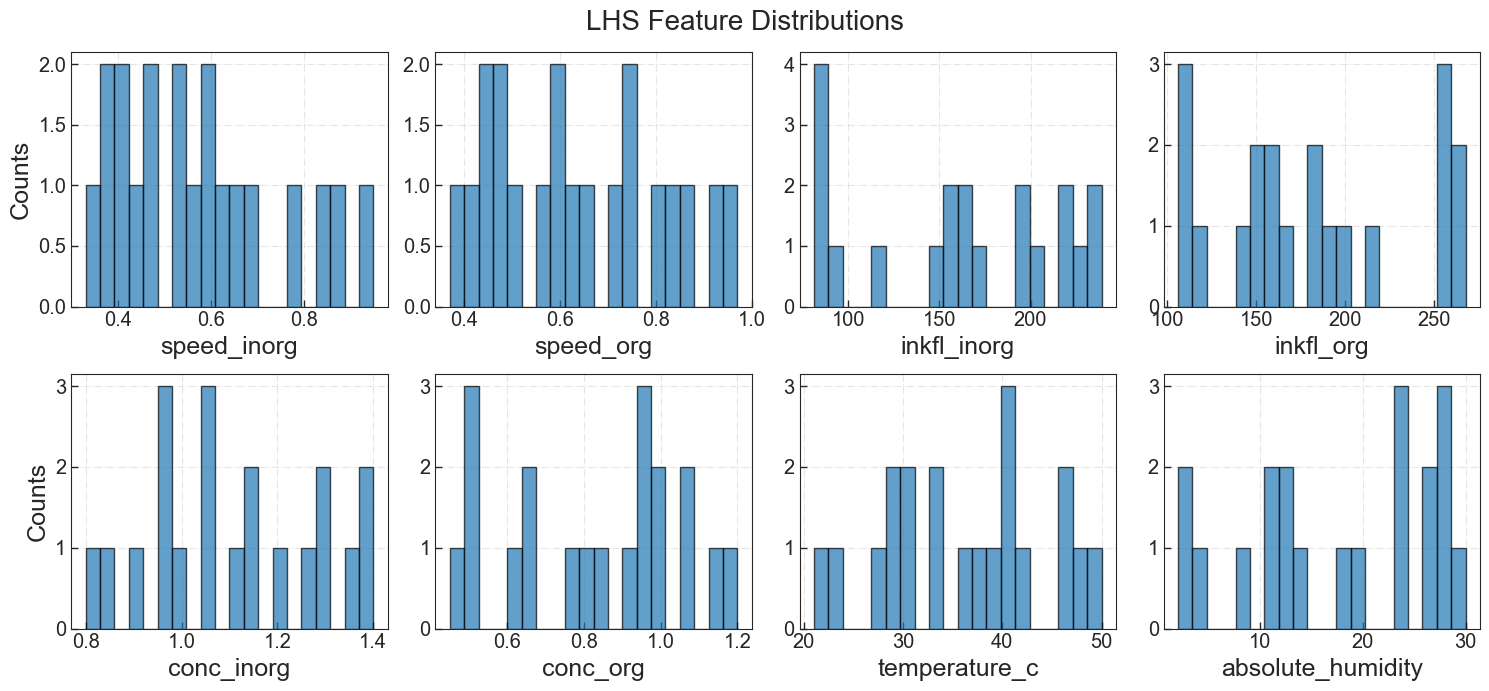

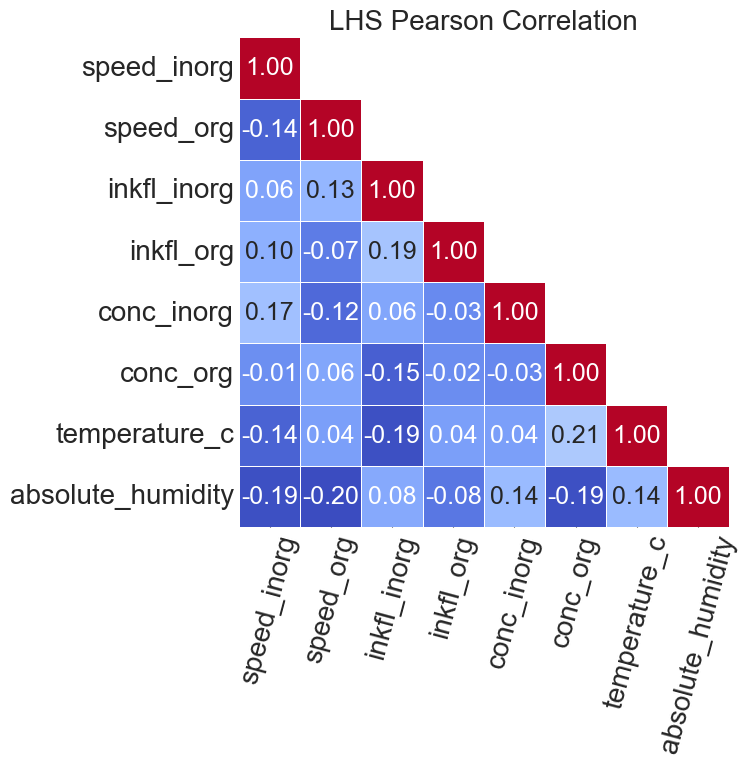

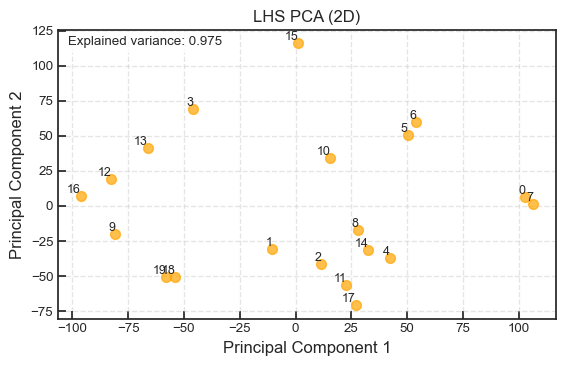

In [5]:
_ = plot_distribution(lhs_df, title="LHS Feature Distributions", save=os.path.join(save_path, "lhs_dist.png"))
_ = plot_correlation_heatmap(lhs_df, title="LHS Pearson Correlation", save=os.path.join(save_path, "lhs_corr.png"))
_ = plot_PCA(lhs_df, title="LHS PCA (2D)", save=os.path.join(save_path, "lhs_pca.png"))

## 2. Normalize Data and Create Tensors/Arrays


**Inputs.** Scale to [0, 1] per dimension. 

This helps GP hyperparameters learn sensibly. There are utility functions to normalize and standardize the outputs, but this is currently handled internally in `fit_gp_models`.

**Tensors.** Some Botorch functions use tensor objects rather than arrays and vice versa. It's good to have both!


In [6]:
# Inputs → [0,1]
X_np = X_df.to_numpy()  ## OR lhs_df
X_norm = x_normalizer_np(X_np, design)

# Tensors
Y_np = Y_df.to_numpy()
(X_t, Y_t), _ = np_to_torch(X_norm, Y_np, device=device, return_device=True)

print("X_scaled shape:", X_t.shape, "Y_scaled shape:", Y_t.shape)


X_scaled shape: torch.Size([11, 8]) Y_scaled shape: torch.Size([11, 3])


## 3. Fit Gaussian Process (GP) Models


We now fit one **Gaussian Process (GP)** per objective (e.g. PCE, Stability, Repeatability).  
This gives us a flexible, uncertainty-aware model of how the objectives vary with process parameters.

- **Defaults:**  
  - Kernel: `MaternKernel(nu=2.5, ard_num_dims=d)` (smooth, ARD per feature)  
  - Likelihood: `GaussianLikelihood` with an inferred homoskedastic noise level  
    (includes a small positive floor to prevent overfitting)

- **Optional overrides:**  
  - You may pass your own **kernel function(s)** (e.g., RBF, Matern with different ν, etc.)  
  - You may pass **noise priors** (e.g., LogNormal or Gamma) to guide the noise estimate.

This example shows passing custom priors and a kernel to demonstrate how it works, but you can omit them entirely to use the defaults.


In [7]:
from gpytorch.priors import LogNormalPrior, GammaPrior
from gpytorch.kernels import MaternKernel, RBFKernel, PeriodicKernel, ConstantKernel

noise_priors = [
    LogNormalPrior(-3.0, 0.5),
    LogNormalPrior(-2.0, 0.5),
    LogNormalPrior(-4.0, 0.5),
]

kernel_fn = lambda d: MaternKernel(nu=2.5, ard_num_dims=d)

model = fit_gp_models(X_t, Y_t, noise_priors=noise_priors, kernel_fn=kernel_fn)

## 4. LOOCV Model Selection (optional)

Instead of hand-choosing kernel functions and noise priors, you can let the repo 
**automatically compare candidates** using **Leave-One-Out Cross-Validation (LOOCV)**.

- The function `loocv_select_models` tries multiple `(kernel × noise)` combinations.
- By default, it uses:
  - **Kernel options:** RBF, Matern(ν=0.5), Matern(ν=1.5), Matern(ν=2.5)  
  - **Noise priors:** `None` (free noise level) and `LogNormal(-4.0, 0.5)`
- For each fold (leave one point out), it re-fits the GP, predicts the held-out point, 
  and records **R²** and **RMSE**.  
- After sweeping all combinations, it selects the best configuration per objective 
  and re-fits on the full dataset.

**Pros:** 
- removes guesswork.
- gives metrics for each option.  

**Cons:** 
- expensive when you have many data points (since it re-fits N×(#kernels×#priors) times).
- poor fits when handling very small and noisy datasets and have convergence errors.

You can skip this step if you are happy with the defaults from Step 3.


In [8]:
from mobo_kit.models import loocv_select_models, default_noise_options, default_kernel_options

noise_options = default_noise_options()
kernel_options = default_kernel_options()

# Run LOOCV across default kernels & priors
best_model, results_df = loocv_select_models(
    train_X=X_t,
    train_Y=Y_t,
    objective_names=obj_names,
    device=device,
)

model_cv = best_model


[fit_gp_models] obj 1: first fit failed (All attempts to fit the model have failed.); retrying with higher noise floor


### Display LOOCV Results

In [9]:
display(results_df)
for i, gp in enumerate(model_cv.models):
    print(f"--- Model {i+1} ({obj_names[i]}) ---")
    # Kernel type
    kernel = gp.covar_module.base_kernel
    print("Kernel:", type(kernel).__name__)

    # Check Matern ν if it's a Matern kernel
    if hasattr(kernel, "nu"):
        print("Matern ν:", kernel.nu)

    # Noise prior info
    if hasattr(gp.likelihood.noise_covar, "noise_prior"):
        prior_type = type(gp.likelihood.noise_covar.noise_prior).__name__
    else:
        prior_type = "None"
    print("Noise prior:", prior_type)
    
    print("Lengthscales:", gp.covar_module.base_kernel.lengthscale.detach().cpu().numpy().flatten())
    print("Outputscale:", gp.covar_module.outputscale.item())
    print("Noise:", gp.likelihood.noise.item())
    print()


,kernel,noise_prior,objective,r2,rmse
0,kernel_0,noise_0,PCE,-0.095,7.717
1,kernel_0,noise_0,Stability,-0.992,2.722
2,kernel_0,noise_0,Repeatability,-0.843,5.771
3,kernel_0,noise_1,PCE,-0.155,7.923
4,kernel_0,noise_1,Stability,-0.812,2.596
5,kernel_0,noise_1,Repeatability,-0.720,5.575
6,kernel_1,noise_0,PCE,-0.078,7.656
7,kernel_1,noise_0,Stability,-0.613,2.450
8,kernel_1,noise_0,Repeatability,-0.830,5.752
9,kernel_1,noise_1,PCE,-0.101,7.737


--- Model 1 (PCE) ---
Kernel: MaternKernel
Matern ν: 2.5
Noise prior: None
Lengthscales: [5.37236911e+03 3.39201652e+03 1.08606536e+00 1.45774745e-01
 2.75569350e+03 3.33731610e+03 2.61430559e+03 1.59973141e+03]
Outputscale: 1.053571483903797
Noise: 0.0010000000474974513

--- Model 2 (Stability) ---
Kernel: MaternKernel
Matern ν: 0.5
Noise prior: GammaPrior
Lengthscales: [3.31144496e+03 3.03708960e+03 1.88583701e+03 1.24681956e-01
 3.12206497e+03 1.19139520e+03 2.24301298e+03 2.20757743e-01]
Outputscale: 0.8376725837046171
Noise: 0.11179251272450567

--- Model 3 (Repeatability) ---
Kernel: MaternKernel
Matern ν: 2.5
Noise prior: None
Lengthscales: [1.37101988e+04 6.35267900e-01 1.10048532e+00 5.26261528e-01
 1.21575333e+00 4.64524827e+03 1.02564717e+04 8.93038769e+03]
Outputscale: 1.2063857907358737
Noise: 0.0010000000474974513



## 5. Posterior Predictions & Diagnostics


With a fitted GP model (`model` from Step 3 or 4), we can now evaluate how well it explains the data.  
This step does two things:

1. **Posterior predictions:**  
   - Use `posterior_report(model, X_t)` to get the **predicted mean** and **uncertainty (std)** for each objective at the training points.  
   - These predictions are automatically converted back into the original units (because the model internally standardizes outputs).

2. **Diagnostics:**  
   - `plot_parity_np` shows **predicted vs. true values** for each objective, with optional error bars from the GP’s predictive uncertainty.  
   - `plot_shap` estimates **feature importance** (mean absolute SHAP values per input dimension), so you can see which process parameters most influence each objective.  
   - `compute_metrics` calculates **R²** and **RMSE**, and can also return per-point residuals and z-scores to help check model fit quality.

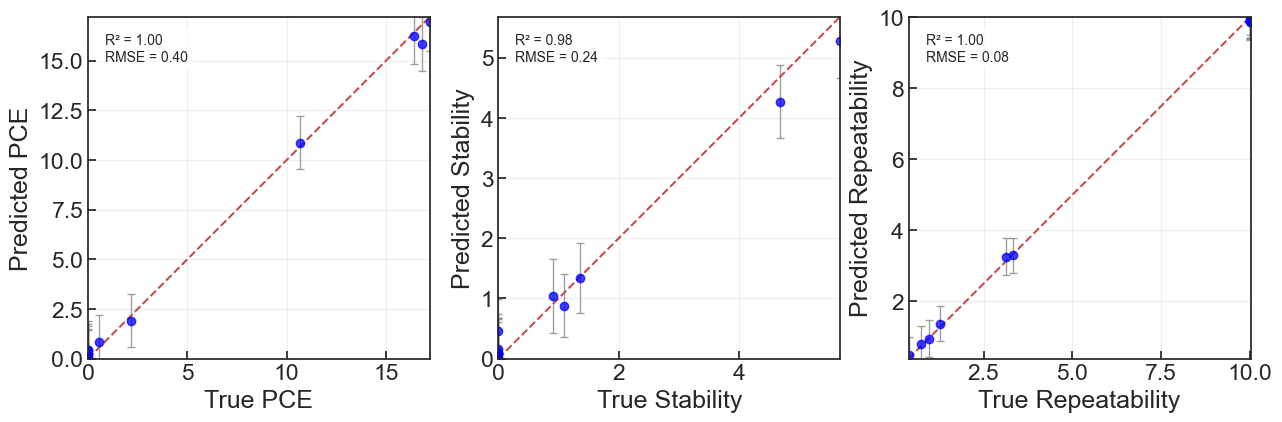

Generating SHAP bar plot for PCE...


100%|██████████| 11/11 [00:00<00:00, 45.86it/s]


⚠️  SHAP values are ~0 for PCE. The GP may be nearly flat or the background is too large/similar.
Generating SHAP bar plot for Stability...


100%|██████████| 11/11 [00:00<00:00, 77.70it/s]


⚠️  SHAP values are ~0 for Stability. The GP may be nearly flat or the background is too large/similar.
Generating SHAP bar plot for Repeatability...


100%|██████████| 11/11 [00:00<00:00, 81.35it/s]


⚠️  SHAP values are ~0 for Repeatability. The GP may be nearly flat or the background is too large/similar.
pred mean range Repeatability: 6.74387824917174 6.74387824917174


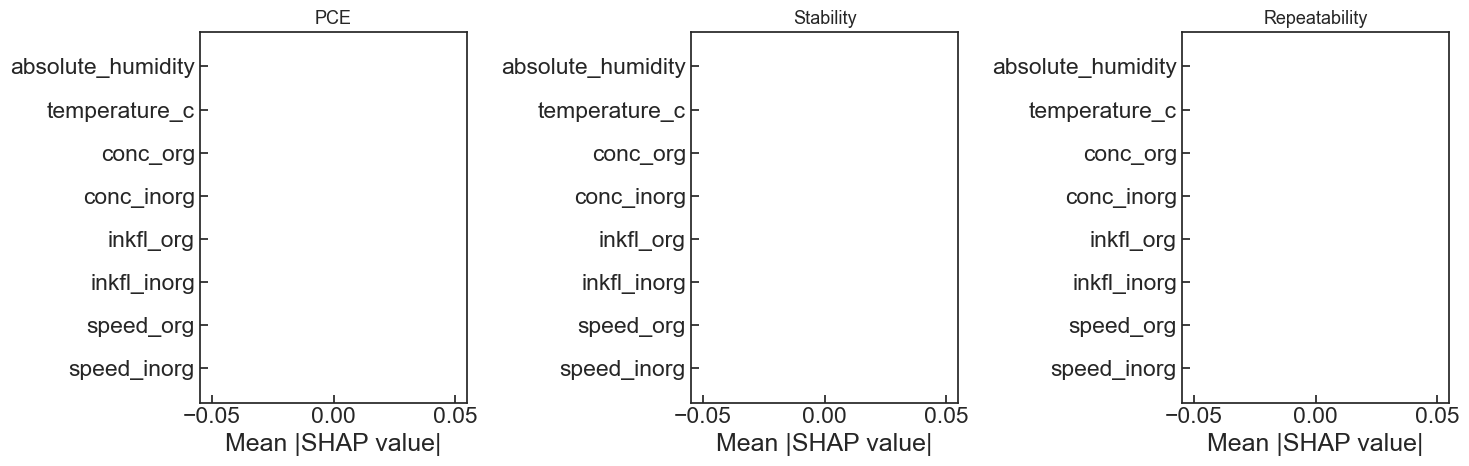

,Objective,R2,RMSE,Residual,Z-score
0,PCE,0.997,0.395,"[0.42972030965195085, 0.1028578524613728, 0.01...","[0.32278933088069184, 0.07541806959159328, 0.0..."
1,Stability,0.984,0.244,"[0.02575635383937147, 0.4510628673960345, 0.08...","[0.04402943925109086, 0.840103682814809, 0.145..."
2,Repeatability,1.000,0.083,"[-0.07264603280082227, -0.06884247617589523, 0...","[-0.14168911616627755, -0.13346299060865513, 0..."


In [10]:
from mobo_kit.models import posterior_report
from mobo_kit.plotting import plot_parity_np, plot_shap
from mobo_kit.metrics import compute_metrics

pred_mean, pred_std = posterior_report(model, X_t)
fig_train, metrics_train = plot_parity_np(Y_np, pred_mean, pred_std, objective_names=obj_names, save=os.path.join(save_path, "parity_train.png"))
fig_shap = plot_shap(design, X_np, model, objective_names=obj_names, save=os.path.join(save_path, "shap.png"))

metrics_df = compute_metrics(
    true_Y=Y_np,               # numpy array of your observed objectives
    pred_mean=pred_mean,
    pred_std=pred_std,
    objective_names=obj_names,
    add_residuals=True,       # set True to include per-point residual vectors
    add_zscores=True,         # set True to include per-point z-score vectors
)
display(metrics_df)

## 6. Acquisition: Pareto Front & Proposing New Experiments

With our GP model trained, we now use an **acquisition function** to decide *where to sample next*.  
In multi-objective BO, we look for candidates that **expand the Pareto front** and improve **hypervolume**.

### Pareto Front & Hypervolume
- The **Pareto front** consists of non-dominated points: no other point is strictly better across *all* objectives.  
- The **hypervolume** measures the space dominated by the Pareto front relative to a chosen **reference point**.  
- As we add better candidates, the hypervolume increases.

In [11]:
from mobo_kit.metrics import compute_ref_pareto_hv

_, pareto_Y_t, hv_val = compute_ref_pareto_hv(Y_t)
ref_point_t = torch.tensor([-0.01, -0.01, -0.01], dtype=X_t.dtype, device=X_t.device)
print("Hypervolume:", hv_val, "| Pareto count:", pareto_Y_t.shape[0])
print(pareto_Y_t)

Hypervolume: 109.02000125445022 | Pareto count: 5
tensor([[ 0.0000,  0.0000, 10.0000],
        [10.6900,  1.3500,  3.3333],
        [16.4300,  5.6800,  0.9524],
        [17.2200,  0.9000,  0.7353],
        [16.8300,  4.6800,  1.2821]], device='cuda:0', dtype=torch.float64)


### Proposing New Candidates

We then call `propose_batch`, which:
1. Builds a **qLogNoisyExpectedHypervolumeImprovement** acquisition function (default).
2. Optimizes it over the normalized design space.
3. Converts back to **physical units**, snapping to valid grids.
4. Enforces row constraints (e.g. Clausius–Clapeyron).
5. Returns a batch of promising candidates.

You can also add **outcome constraints** (e.g. enforce PCE ≥ 15%).

### Balancing Exploration vs. Exploitation

The following parameters influence the tradeoff:
- num_restarts and raw_samples: higher values → more global search (exploration).
- sample_shape (MC samples): larger → more accurate acquisition evaluation, but slower.
- sequential:
    - True → proposes candidates one-by-one, each conditioned on the last (more exploitative).
    - False → proposes all in parallel (more exploratory, but less coordinated).
- Outcome constraints can bias selection toward “safe” regions, shifting away from exploration.

In practice:
- For early rounds, set larger raw_samples (e.g. 1024) and keep sequential=False to encourage exploration.
- For later rounds, reduce these and turn sequential=True to refine promising regions (exploitation).

In [12]:
from mobo_kit.acquisition import propose_batch, outcome_ge, outcome_le

row_constraints = constraints_from_config(config, design)
pce_threshold = 15.0  # Example: 15% PCE minimum
repeatability_threshold = 8  # Example: 0.1 maximum repeatability

outcome_constraints = [
        outcome_ge(obj_idx=0, thresh=pce_threshold),  # PCE >= 15%
        outcome_le(obj_idx=2, thresh=repeatability_threshold),  # Repeatability <= 0.1
    ]

out = propose_batch(design, model, X_t, ref_point_t, batch_size=5, row_constraints=row_constraints, verbose=True)

In [13]:
print(out.keys())

dict_keys(['X_phys', 'X_norm', 'acq_val', 'attempts'])


## 7. Review Proposed Batch & Predicted Outcomes

Now that we’ve generated candidates, let’s:
1) **Inspect the proposed settings** in original (physical) units.  
2) **Interpret acquisition values** (log nEHVI → EHVI).  
3) **Preview model predictions** (mean ± uncertainty) for each objective at the proposed points.

### 1) Inspect the proposed candidates
- `out["X_phys"]` is already **de-normalized and snapped** to any discrete grids defined in the `Design`.
- We display it as a tidy dataframe with the original column names.

### 2) Acquisition values (how “good” each candidate is)
- With `use_lognehvi=True` (default), `out["acq_val"]` contains **log(EHVI)** for numerical stability.  
- Exponentiate to get **EHVI** (expected hypervolume improvement).  
- Larger EHVI ⇒ greater expected contribution to the Pareto front.

### 3) Predicted outcomes for the proposed batch
- We pass the **normalized** candidates (`out["X_norm"]`) through the fitted model.  
- The bar plot shows **mean** predictions with **uncertainty bars** (predictive std) for each objective.

> Notes
> - Objectives are assumed to be **maximized** here. If you minimize any objective, flip the sign upstream for consistency.
> - Before running the batch in the lab, you can optionally **save** the table to CSV (e.g., `X_next.to_csv(...)`) to hand off to execution.



array([[  0.72,   1.  , 107.  , 114.  ,   0.8 ,   1.15,  36.  ,  17.  ],
       [  0.67,   1.  ,  80.  , 106.  ,   1.4 ,   0.95,  35.  ,  16.  ],
       [  1.  ,   1.  , 163.  , 124.  ,   0.8 ,   0.65,  34.  ,  17.  ],
       [  0.26,   1.  , 240.  , 104.  ,   0.8 ,   1.1 ,  46.  ,  18.  ],
       [  0.99,   0.79,  80.  , 131.  ,   0.8 ,   0.6 ,  43.  ,  19.  ]])

Acquisition Value Analysis:
   Raw acquisition values (log(nEHVI)): ['6.515857', '4.974080', '4.554099', '4.047132', '3.942164']
   Actual EHVI values: ['675.772709', '144.615785', '95.021141', '57.233100', '51.529998']


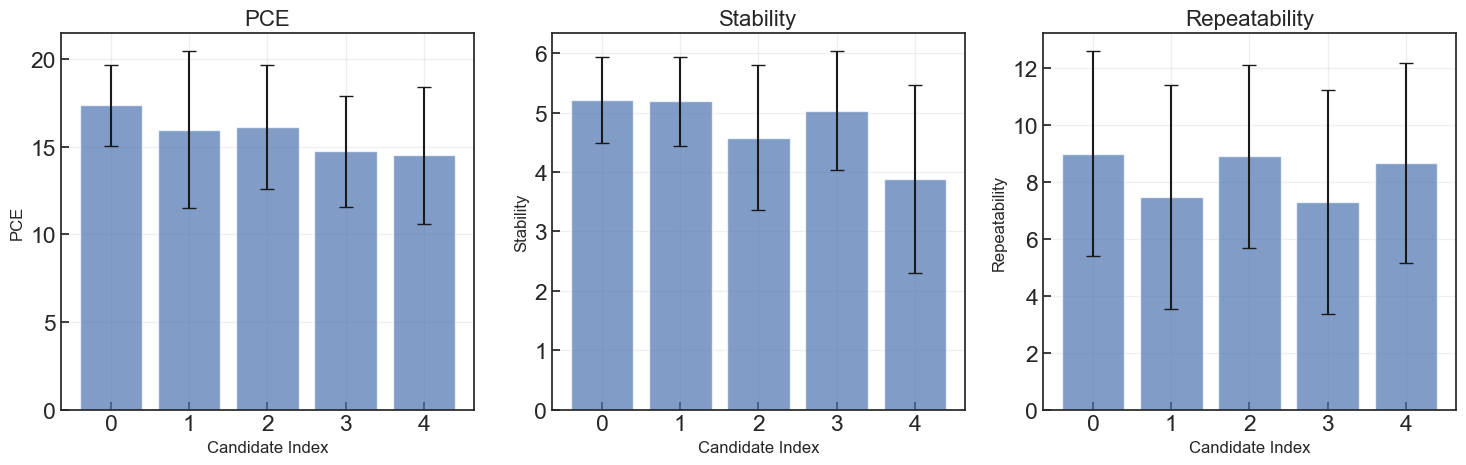

In [14]:
from mobo_kit.plotting import plot_bar

# 1. Display proposed candidates
X_next = out["X_phys"]
X_next_df = pd.DataFrame(out["X_phys"], columns=design.names)
display(X_next)

# 2. Acquisition value analysis
print(f"Acquisition Value Analysis:")
print(f"   Raw acquisition values (log(nEHVI)): {[f'{v:.6f}' for v in out['acq_val']]}")
# Convert from log(EHVI) to EHVI since use_lognehvi=True (default)
ehvi_values = [np.exp(v) for v in out['acq_val']]
print(f"   Actual EHVI values: {[f'{v:.6f}' for v in ehvi_values]}")

# 3. Predicted outcomes for the proposed batch
X_norm = out["X_norm"]
X_norm_t = np_to_torch(X_norm, device=X_t.device)
pred_mean_new, pred_std_new = posterior_report(model, X_norm_t)

fig_bar = plot_bar(pred_mean_new, pred_std_new, labels=obj_names, save=os.path.join(save_path, "proposed_bar.png"))

## 8. Visualize Your Progress (Work in Progress...)

We track learning progress by plotting the **hypervolume (HV)** after each batch of **observed** results.  
As you collect new data and the Pareto front improves, HV should **monotonically increase** (or stay flat).

**Key points**
- Use **observed outcomes** (not predictions).  
- Keep a **fixed reference point** `ref_point_t` across all batches (choose it once at the start, slightly worse than the worst feasible values for each objective, in original units).  
- Compute HV on the **cumulative dataset** up through each batch.

Current HV (observed data): 147.982664 | Pareto count: 5
Demo HV with predictions: 824.119981 | Pareto count: 3


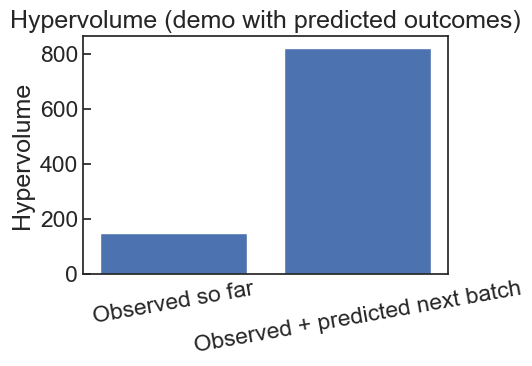

In [15]:
# 1) Reference point (original units) — pick once and keep fixed across batches
ref_point_np = np.array([-0.01, -0.01, -0.01])

# 2) HV on current observed data
_, pareto_Y_t, hv_val = compute_ref_pareto_hv(Y_t, ref_point_np)
print(f"Current HV (observed data): {hv_val:.6f} | Pareto count: {pareto_Y_t.shape[0]}")

# 3) Append predicted means for proposed batch (demo only)
Y_next_t = np_to_torch(pred_mean_new, device=Y_t.device)
combined_Y = torch.cat([Y_t, Y_next_t], dim=0)

_, pareto_Y_combined, hv_val_combined = compute_ref_pareto_hv(combined_Y, ref_point_np)
print(f"Demo HV with predictions: {hv_val_combined:.6f} | Pareto count: {pareto_Y_combined.shape[0]}")

# 4) Simple before/after plot
hv_vals = [hv_val, hv_val_combined]
labels = ["Observed so far", "Observed + predicted next batch"]

plt.figure(figsize=(5.5, 4))
plt.bar(range(len(hv_vals)), hv_vals)
plt.xticks(range(len(hv_vals)), labels, rotation=10)
plt.ylabel("Hypervolume")
plt.title("Hypervolume (demo with predicted outcomes)")
plt.tight_layout()
plt.savefig(os.path.join(save_path, "hv_demo_with_predictions.png"), dpi=200)
plt.show()

This plot shows the **current Pareto front** (green) in 3D objective space and an optional **predicted next batch**.  

The **reference point** is drawn as a red star.

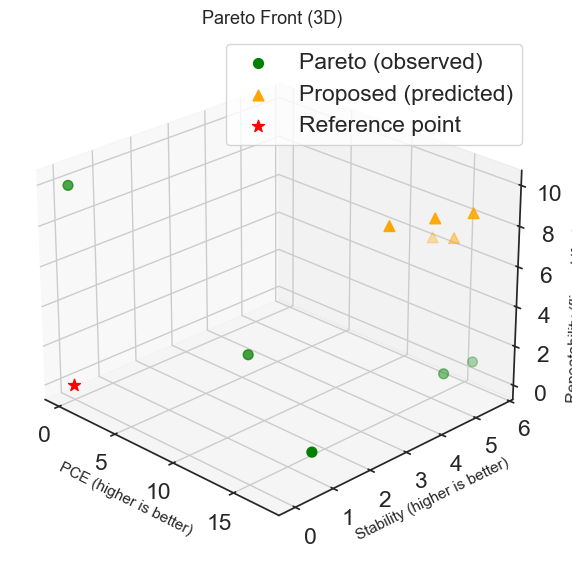

In [16]:
# --- Settings: mark which objectives are maximized ---
# Example: [PCE (max), Stability (max), Repeatability (min)]
maximize = [True, True, True]

def _flip_for_plot(Y_t, maximize_flags):
    """
    Convert a (K, M) tensor Y_t to numpy and flip any minimized objectives
    so that all axes read 'higher is better' in the plot.
    """
    Y_np = Y_t.detach().cpu().numpy().copy()
    for j, is_max in enumerate(maximize_flags):
        if not is_max:
            Y_np[:, j] = -Y_np[:, j]
    return Y_np

# Prepare arrays (Pareto + reference point, both already in ORIGINAL units)
pareto_Y_np_plot = _flip_for_plot(pareto_Y_t, maximize)
ref_point_np_plot = _flip_for_plot(ref_point_t.view(1, -1), maximize)

# Optional: include predicted outcomes for the newly proposed batch
# (Uncomment if you have Y_next_t from earlier demo code)
has_next = 'Y_next_t' in globals()
if has_next and Y_next_t is not None:
    next_Y_np_plot = _flip_for_plot(Y_next_t, maximize)

# --- 3D scatter ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Pareto points (observed)
ax.scatter(
    pareto_Y_np_plot[:, 0], pareto_Y_np_plot[:, 1], pareto_Y_np_plot[:, 2],
    c='green', s=50, label='Pareto (observed)', depthshade=True
)

# Optional: predicted next batch
if has_next and Y_next_t is not None:
    ax.scatter(
        next_Y_np_plot[:, 0], next_Y_np_plot[:, 1], next_Y_np_plot[:, 2],
        c='orange', s=60, marker='^', label='Proposed (predicted)', depthshade=True
    )

# Reference point
ax.scatter(
    ref_point_np_plot[0, 0], ref_point_np_plot[0, 1], ref_point_np_plot[0, 2],
    c='red', s=80, marker='*', label='Reference point'
)

# Axis labels (update names to your objectives if needed)
ax.set_xlabel('PCE (higher is better)', fontsize=11)
ax.set_ylabel('Stability (higher is better)', fontsize=11)
ax.set_zlabel('Repeatability (flipped if minimized)', fontsize=11)

ax.set_title('Pareto Front (3D)', fontsize=13)
ax.legend(loc='best')
ax.view_init(elev=25, azim=-45)
plt.tight_layout()
# Optionally save:
# plt.savefig(os.path.join(save_path, "pareto_3d.png"), dpi=200)
plt.show()


## 9. Save Outputs


Get it right back into that same file format you so tirelessly created!


In [17]:
Y_next_df = pd.DataFrame(pred_mean_new, columns=obj_names)
df_new = pd.concat([X_next_df, Y_next_df], axis=1)

df_batch_1 = pd.concat([df, df_new], axis=0)
df_batch_1.to_csv(os.path.join(save_path, "batch_1.csv"), index=False)